# Data Extraction & Analyse

In [1]:
from time import sleep
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from msedge.selenium_tools import Edge, EdgeOptions
from selenium.webdriver.support.wait import WebDriverWait
import selenium.webdriver.support.expected_conditions as EC
from pymongo import MongoClient
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pandas as pd  # For handling time series data
from wordcloud import WordCloud

# Function to extract tweet data from a tweet article
def get_tweet_data(article):
    try:
        user = article.find_element(By.CSS_SELECTOR, 'div[data-testid="User-Name"]').text.split('\n')
        name = user[0]
        username = user[1]
        postdate = user[-1]
        tweetText = article.find_element(By.XPATH, ".//div[@data-testid='tweetText']").text
        reply_count = article.find_element(By.XPATH, ".//div[@data-testid='reply']").text
        retweet_count = article.find_element(By.XPATH, ".//div[@data-testid='retweet']").text
        like_count = article.find_element(By.XPATH, ".//div[@data-testid='like']").text

        return {
            "name": name,
            "username": username,
            "postdate": postdate,
            "tweetText": tweetText,
            "reply_count": reply_count,
            "retweet_count": retweet_count,
            "like_count": like_count,
            "timestamp": pd.Timestamp.now()  # Add timestamp to tweet data
        }
    except StaleElementReferenceException:
        # Handle stale element exception by returning None
        return None

# Function to perform sentiment analysis on text
def analyze_sentiment(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Calculate sentiment scores using VADER
    scores = sid.polarity_scores(text)
    # Determine sentiment based on compound score
    if scores['compound'] >= 0.05:
        return 'positive', tokens
    elif scores['compound'] <= -0.05:
        return 'negative', tokens
    else:
        return 'neutral', tokens

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  # Update with your MongoDB connection string
db1 = client["twitter1"]  # Database for tweets without sentiment analysis
collection1 = db1["tweets"]  # Collection for tweets without sentiment analysis

db2 = client["twitter2"]  # Database for tweets with sentiment analysis
collection2 = db2["tweets"]  # Collection for tweets with sentiment analysis

# Initialize NLTK's sentiment analyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon for sentiment analysis
sid = SentimentIntensityAnalyzer()

options = EdgeOptions()
options.use_chromium = True
options.add_argument("--start-maximized")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
driver = Edge(options=options)

wait = WebDriverWait(driver, 10)
driver.get("https://twitter.com/login")

username = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[name="text"]')))
username.send_keys("your username") #Make sure to enter ur twitter username here !!!!!!  
username.send_keys(Keys.ENTER)

password = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[name="password"]')))
password.send_keys('your password') #Make sure to enter ur twitter password here !!!!!!
password.send_keys(Keys.ENTER)

search_box = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[data-testid="SearchBox_Search_Input"]')))
search_box.send_keys('#Morocco')
search_box.send_keys(Keys.ENTER)

wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, 'article[data-testid="tweet"]')))

tweet_text_all = ""  # Initialize variable to store all tweet text

# Store tweet data temporarily
tweet_data = []

# Store sentiment counts
sentiment_data = {'positive': 0, 'neutral': 0, 'negative': 0}

# Store hashtag counts
hashtag_data = {}

# Store timestamps
timestamps = []

last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_articles = driver.find_elements(By.CSS_SELECTOR, 'article[data-testid="tweet"]')
    for article in page_articles:
        tweet = get_tweet_data(article)
        if tweet:
            tweet_data.append(tweet)
            # Concatenate tweet text for word cloud generation
            tweet_text_all += tweet["tweetText"] + " "

            # Perform sentiment analysis on the tweet text
            text = tweet["tweetText"]
            sentiment, _ = analyze_sentiment(text)

            # Update sentiment counts
            sentiment_data[sentiment] += 1

            # Extract hashtags and update hashtag counts
            hashtags = [tag.strip("#") for tag in tweet["tweetText"].split() if tag.startswith("#")]
            for hashtag in hashtags:
                hashtag_data[hashtag] = hashtag_data.get(hashtag, 0) + 1

            # Store timestamp
            timestamps.append(tweet["timestamp"])

    scroll_attempt = 0
    while True:
        driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
        sleep(3)
        current_position = driver.execute_script("return window.pageYOffset;")
        if last_position == current_position:
            scroll_attempt += 1

            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2)
        else:
            last_position = current_position
            break

# Insert tweet data into MongoDB collection 1 (tweets without sentiment analysis)
collection1.insert_many(tweet_data)

# Perform sentiment analysis and store results in MongoDB collection 2
for tweet in tweet_data:
    text = tweet["tweetText"]
    sentiment, _ = analyze_sentiment(text)
    tweet["sentiment"] = sentiment  # Add sentiment to tweet data
    collection2.insert_one(tweet)

# Close the browser and MongoDB connection
driver.quit()
client.close()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\HP\AppData\Local\Temp\ipykernel_22008\2806324646.py:71: DeprecationWarning: Selenium Tools for Microsoft Edge is deprecated. Please upgrade to Selenium 4 which has built-in support for Microsoft Edge (Chromium): https://docs.microsoft.com/en-us/microsoft-edge/webdriver-chromium/#upgrading-from-selenium-3
  driver = Edge(options=options)


# Visualization

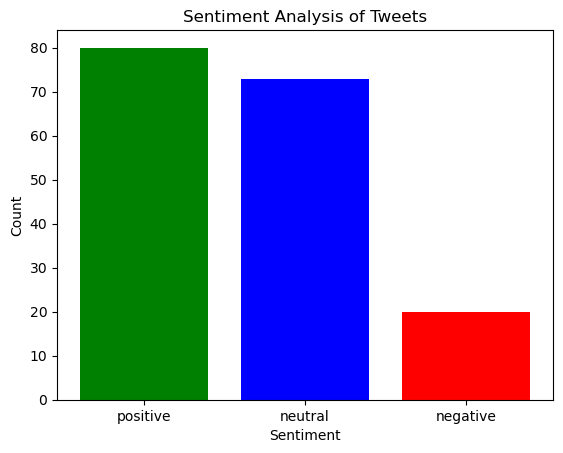

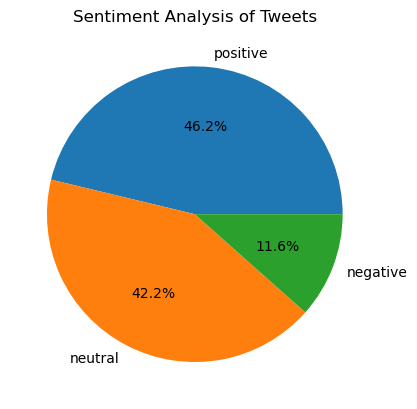

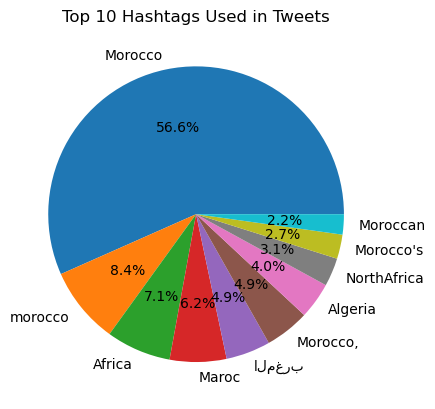

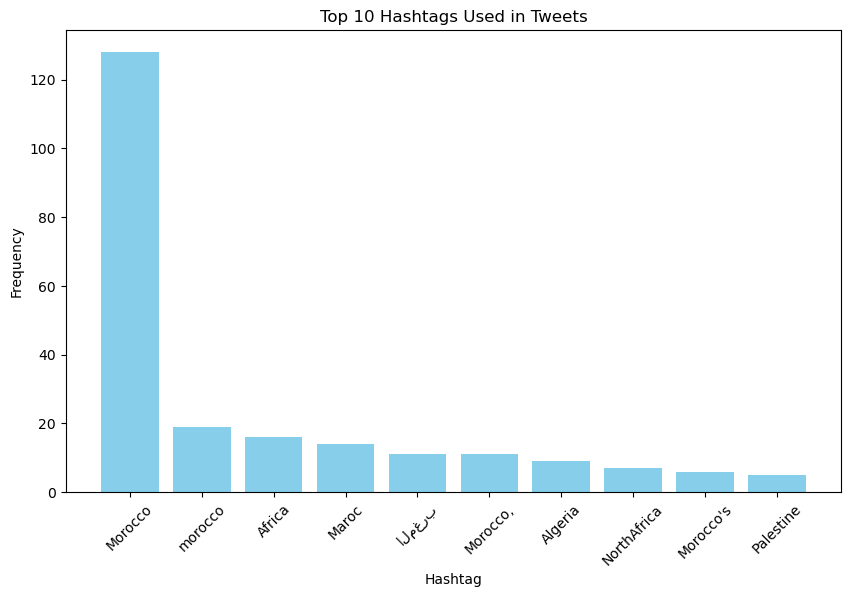

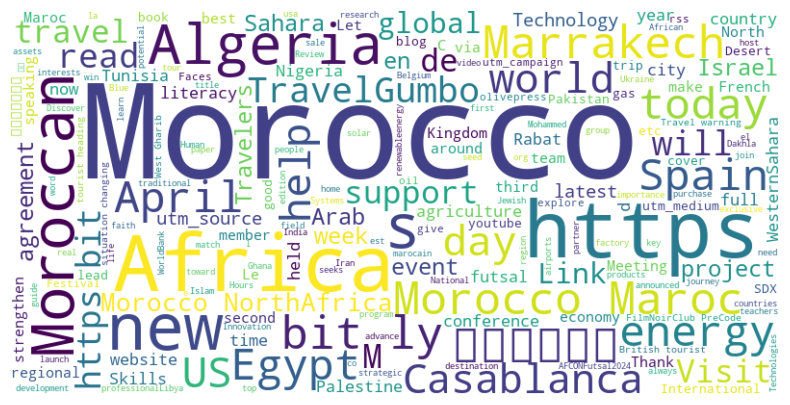

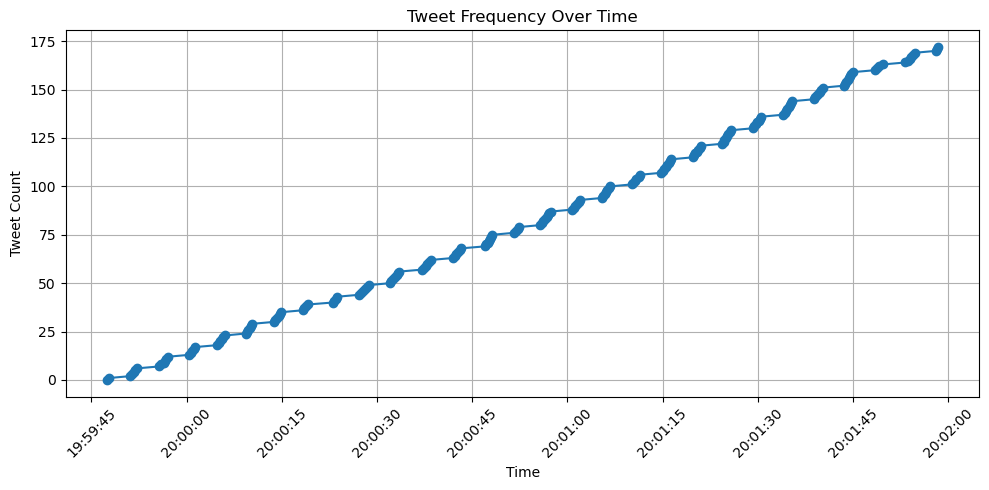

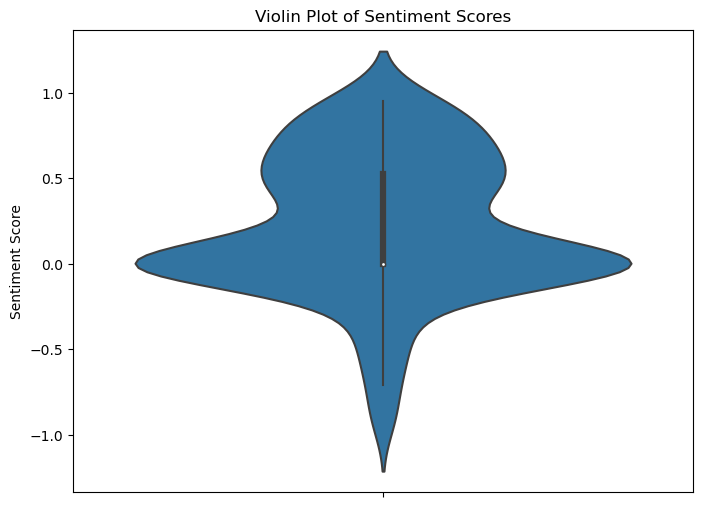

In [2]:

# Function to visualize bar plot for sentiments
def visualize_bar_plot_sentiments(sentiment_data):
    labels = list(sentiment_data.keys())
    values = list(sentiment_data.values())
    plt.bar(labels, values, color=['green', 'blue', 'red'])
    plt.title('Sentiment Analysis of Tweets')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Function to visualize pie chart for sentiments
def visualize_pie_chart_sentiments(sentiment_data):
    labels = list(sentiment_data.keys())
    values = list(sentiment_data.values())
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title('Sentiment Analysis of Tweets')
    plt.show()

# Function to visualize bar plot for top hashtags (excluding top 10)
def visualize_top_hashtags_bar(hashtag_data):
    top_hashtags = sorted(hashtag_data.items(), key=lambda x: x[1], reverse=True)[10:]
    labels = [entry[0] for entry in top_hashtags]
    values = [entry[1] for entry in top_hashtags]
    plt.bar(labels, values, color='skyblue')
    plt.title('Top Hashtags (Excluding Top 10)')
    plt.xlabel('Hashtag')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
def visualize_top_hashtags_pie(hashtag_data):
    top_hashtags = sorted(hashtag_data.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = [entry[0] for entry in top_hashtags]
    values = [entry[1] for entry in top_hashtags]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title('Top 10 Hashtags Used in Tweets')
    plt.show()


# Visualize bar plot for sentiments
visualize_bar_plot_sentiments(sentiment_data)

# Visualize pie chart for sentiments
visualize_pie_chart_sentiments(sentiment_data)


visualize_top_hashtags_pie(hashtag_data)

# Visualize hashtag frequency
hashtag_df = pd.DataFrame(list(hashtag_data.items()), columns=['Hashtag', 'Frequency'])
top_hashtags = hashtag_df.sort_values(by='Frequency', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_hashtags['Hashtag'], top_hashtags['Frequency'], color='skyblue')
plt.title('Top 10 Hashtags Used in Tweets')
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tweet_text_all)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()
# Convert list of timestamps to pandas datetime series
timestamps_series = pd.Series(timestamps)

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(timestamps_series, range(len(timestamps_series)), marker='o', linestyle='-')
plt.title('Tweet Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


import seaborn as sns

# Extract sentiment scores from tweet data
sentiment_scores = [sid.polarity_scores(tweet["tweetText"])["compound"] for tweet in tweet_data]

# Create a DataFrame for sentiment scores
sentiment_df = pd.DataFrame({"Sentiment Score": sentiment_scores})

# Plot violin plot for sentiment scores
plt.figure(figsize=(8, 6))
sns.violinplot(data=sentiment_df, y="Sentiment Score")
plt.title("Violin Plot of Sentiment Scores")
plt.ylabel("Sentiment Score")
plt.show()
